In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import confusion_matrix
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
dataset = pd.read_csv('/content/davidson_dataset.csv')
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)
print(dataset.head())

   Unnamed: 0  ...  text length
0           0  ...          140
1           1  ...           85
2           2  ...          120
3           3  ...           62
4           4  ...          137

[5 rows x 8 columns]


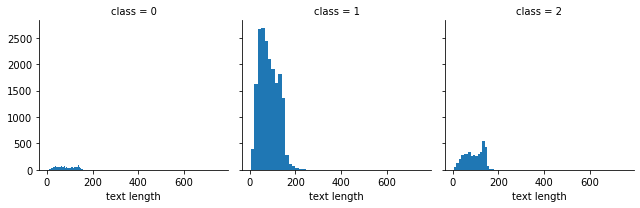

In [4]:
# FacetGrid- Multi-plot grid for plotting conditional relationships

graph = sns.FacetGrid(data = dataset, col ='class')
graph.map(plt.hist, 'text length', bins = 50)

In [5]:
# collecting only the tweets from the csv file into a variable name tweet
tweet = dataset.tweet

## Preprocessing of the tweets

In [6]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
print(dataset[["tweet","processed_tweets"]].head(10))

                                               tweet                                   processed_tweets
0  !!! RT @mayasolovely: As a woman you shouldn't...  woman complain clean hous amp man alway take t...
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  boy dat cold tyga dwn bad cuffin dat hoe st place
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...         dawg ever fuck bitch start cri confus shit
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...                                   look like tranni
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...     shit hear might true might faker bitch told ya
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...      shit blow claim faith somebodi still fuck hoe
6  !!!!!!"@__BrighterDays: I can not just sit up ...              sit hate anoth bitch got much shit go
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...            caus tire big bitch come us skinni girl
8  " &amp; you might not get ya bitch back &amp; ...            

## Feature Engineering

In [7]:
#TF-IDF Features-F1
# TF-IDF feature matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'])
print(tfidf)

  (0, 5549)	0.4309517500614609
  (0, 5823)	0.21292360474103067
  (0, 5536)	0.2694725323170756
  (0, 103)	0.2848504306418305
  (0, 3639)	0.2500076439754137
  (0, 124)	0.22951771468335722
  (0, 2896)	0.32473278046308335
  (0, 1189)	0.37180372772740344
  (0, 1266)	0.37805333846740247
  (0, 6262)	0.33673876130852654
  (1, 1455)	0.35408569797294004
  (1, 4385)	0.29402989193760287
  (1, 5340)	0.3008029767463628
  (1, 2717)	0.12204320836205955
  (1, 1388)	0.37776257623201304
  (1, 321)	0.20828940991978914
  (1, 5944)	0.35642794983844883
  (1, 1221)	0.3008029767463628
  (1, 1453)	0.47084617485060926
  (1, 892)	0.2397588136195512
  (2, 723)	0.4025857370799935
  (2, 2121)	0.26875711871483904
  (2, 1802)	0.4334907503536408
  (2, 5054)	0.19413584053699529
  (2, 1279)	0.366125652299236
  :	:
  (24780, 960)	0.343011332843257
  (24780, 63)	0.37409643142606824
  (24780, 4095)	0.26604418498734955
  (24780, 1544)	0.2613777761879398
  (24780, 2187)	0.2280990649157048
  (24780, 1713)	0.21384505532921141
 

### Running various model Using TFIDF without additional features

In [8]:
# If you don't specify the random_state in the code, 
# then every time you run(execute) your code a new random value is generated 
# and the train and test datasets would have different values each time.
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report(y_test, y_preds )
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)


              precision    recall  f1-score   support

           0       0.56      0.18      0.27       290
           1       0.92      0.96      0.94      3832
           2       0.85      0.84      0.85       835

    accuracy                           0.90      4957
   macro avg       0.77      0.66      0.68      4957
weighted avg       0.88      0.90      0.88      4957

Logistic Regression, Accuracy Score: 0.8975186604801291


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [9]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

           0       0.50      0.15      0.23       290
           1       0.93      0.96      0.94      3832
           2       0.83      0.91      0.87       835

    accuracy                           0.90      4957
   macro avg       0.75      0.67      0.68      4957
weighted avg       0.89      0.90      0.89      4957

Random Forest, Accuracy Score: 0.9023602985676821


In [10]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.58      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957

Naive Bayes, Accuracy Score: 0.6491829735727255


In [11]:
support = LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.46      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.85      0.84       835

    accuracy                           0.89      4957
   macro avg       0.74      0.69      0.70      4957
weighted avg       0.88      0.89      0.89      4957

SVM, Accuracy Score: 0.8932822271535202


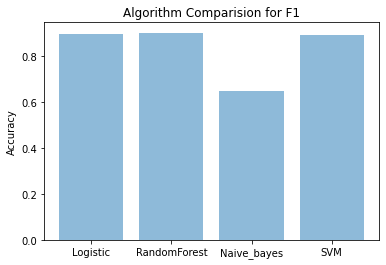

In [12]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F1')
plt.show()

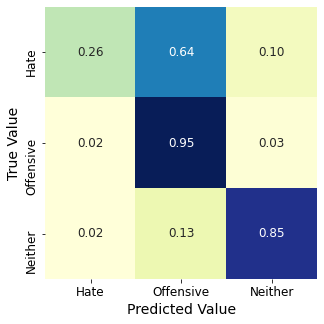

In [13]:
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

### Sentiment Analysis, using polarity scores as features

In [14]:
sentiment_analyzer = VS()
def count_tags(tweet_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pd.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0
3,0.000,0.344,0.656,0.5673,0.0,2.0,0.0
4,0.249,0.081,0.669,-0.7762,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24779,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0
24780,0.000,0.219,0.781,0.4738,0.0,0.0,0.0
24781,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


In [15]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24783, 6448)

### Running various model Using TFIDF and additional features

In [16]:
# Running the model Using TFIDF with some features from sentiment analysis

X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.59      0.19      0.28       290
           1       0.92      0.96      0.94      3832
           2       0.85      0.86      0.85       835

    accuracy                           0.90      4957
   macro avg       0.78      0.67      0.69      4957
weighted avg       0.89      0.90      0.89      4957

Logistic Regression, Accuracy Score: 0.900342949364535


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [17]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

           0       0.52      0.13      0.21       290
           1       0.91      0.96      0.94      3832
           2       0.84      0.84      0.84       835

    accuracy                           0.89      4957
   macro avg       0.76      0.65      0.66      4957
weighted avg       0.88      0.89      0.88      4957

Random Forest, Accuracy Score: 0.8942909017550938


In [18]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train_bow,y_train)
y_preds = nb.predict(X_test_bow)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.59      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957

Naive Bayes, Accuracy Score: 0.650191648174299


In [19]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.46      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.85      0.84       835

    accuracy                           0.89      4957
   macro avg       0.74      0.69      0.70      4957
weighted avg       0.88      0.89      0.88      4957

SVM, Accuracy Score: 0.891466612870688


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


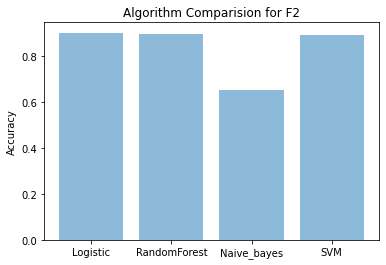

In [20]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F2')
plt.show()

In [21]:
# confusion_matrix = confusion_matrix(y_test,y_preds)
# matrix_proportions = np.zeros((3,3))
# for i in range(0,3):
#     matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
# names=['Hate','Offensive','Neither']
# confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
# plt.figure(figsize=(5,5))
# sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
# plt.ylabel(r'True Class',fontsize=14)
# plt.xlabel(r'Predicted Class',fontsize=14)
# plt.tick_params(labelsize=12)

In [22]:
# create doc2vec vector columns
# Initialize and train the model

#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]). 
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_tweets"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = dataset["processed_tweets"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,0.072011,0.028262,0.013007,-0.031722,0.029841
1,0.155015,-0.076165,0.131011,0.047017,0.052677
2,0.091201,-0.000911,-0.084334,0.063971,0.097844
3,-0.044433,0.041983,0.087000,0.047607,0.060300
4,0.098895,0.073085,0.087959,-0.025063,-0.068433
...,...,...,...,...,...
24778,0.268599,-0.100037,0.168223,0.114593,0.052692
24779,0.103795,0.013489,-0.002311,0.049559,-0.091732
24780,0.098303,0.042347,0.043432,-0.076464,0.108152
24781,0.007689,0.004044,-0.018892,0.038287,0.037303


In [23]:
# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(24783, 6453)

### Running the models Using TFIDF with additional features from sentiment analysis and doc2vec

In [24]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.59      0.19      0.28       290
           1       0.91      0.97      0.94      3832
           2       0.85      0.84      0.84       835

    accuracy                           0.90      4957
   macro avg       0.78      0.66      0.69      4957
weighted avg       0.88      0.90      0.88      4957

Logistic Regression, Accuracy Score: 0.8981238652410732


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

           0       0.51      0.08      0.13       290
           1       0.90      0.97      0.94      3832
           2       0.86      0.81      0.83       835

    accuracy                           0.89      4957
   macro avg       0.76      0.62      0.63      4957
weighted avg       0.87      0.89      0.87      4957

Random Forest, Accuracy Score: 0.8918700827113173


In [26]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.59      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957

Naive Bayes, Accuracy Score: 0.650191648174299


In [27]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.44      0.25      0.32       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.86      0.84       835

    accuracy                           0.89      4957
   macro avg       0.73      0.68      0.70      4957
weighted avg       0.88      0.89      0.88      4957

SVM, Accuracy Score: 0.891466612870688


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


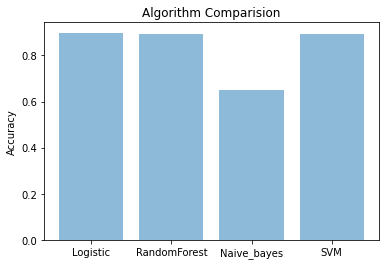

In [28]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align = 'center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

In [29]:
# confusion_matrix = confusion_matrix(y_test,y_preds)
# matrix_proportions = np.zeros((3,3))
# for i in range(0,3):
#     matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
# names=['Hate','Offensive','Neither']
# confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
# plt.figure(figsize=(5,5))
# sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
# plt.ylabel(r'True Class',fontsize=14)
# plt.xlabel(r'Predicted Class',fontsize=14)
# plt.tick_params(labelsize=12)

In [30]:
#Using TFIDF with sentiment scores,doc2vec and enhanced features
def additional_features(tweet): 
    
    syllables = textstat.syllable_count(tweet)
    num_chars = sum(len(w) for w in tweet)
    num_chars_total = len(tweet)
    num_words = len(tweet.split())
    # avg_syl = total syllables/ total words
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(tweet.split()))
    
    #  Flesch–Kincaid readability tests are readability tests
    # Modified FK grade, where avg words per sentence is : just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    # Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    add_features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(tweets):
    features = []
    for t in tweets:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(processed_tweets)

In [31]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,final_features,doc2vec_df,fFeatures],axis=1)
modelling_features_enhanced.shape

(24783, 6461)

### Running the models Using TFIDF with sentiment scores,doc2vec and enhanced features

In [32]:
# Running the model Using TFIDF with enhanced features

X = pd.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train_features,y_train)
y_preds = model.predict(X_test_features)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.82      0.96      0.88      3852
           2       0.61      0.31      0.41       826

    accuracy                           0.80      4957
   macro avg       0.47      0.42      0.43      4957
weighted avg       0.74      0.80      0.75      4957

Logistic Regression, Accuracy Score: 0.7982650796852935


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
testing_index=list(X_test_features.index[0:10])
print(testing_index)

[4129, 15081, 16547, 4273, 4254, 4857, 16974, 6609, 8946, 23210]


In [34]:
print("Predicted Class:",y_preds[0:10])
print("Actual Class:",y_test.tolist()[0:10])

Predicted Class: [1 1 1 1 1 1 1 1 1 1]
Actual Class: [2, 1, 1, 0, 2, 1, 1, 1, 2, 2]


Text(0, 0.5, 'Count')

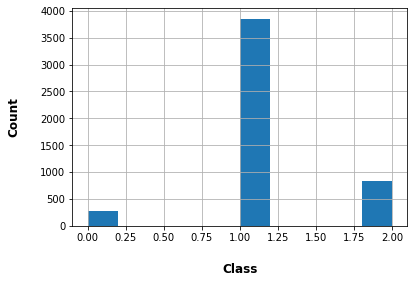

In [35]:
# Histogram presenting the count of different classes - Actual
ax=y_test.hist()
ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

Text(0, 0.5, 'Count')

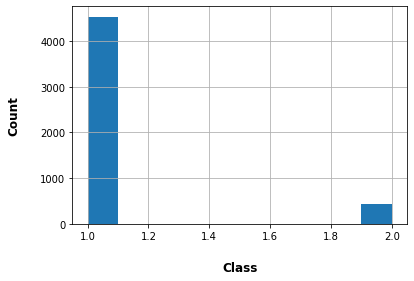

In [36]:
# Histogram presenting the count of different classes - Predicted
ax = pd.Series(y_preds).hist()
ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

In [37]:
X = pd.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train_features,y_train)
y_preds = rf.predict(X_test_features)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

           0       0.48      0.04      0.07       279
           1       0.89      0.97      0.93      3852
           2       0.85      0.72      0.78       826

    accuracy                           0.88      4957
   macro avg       0.74      0.58      0.59      4957
weighted avg       0.86      0.88      0.86      4957

Random Forest, Accuracy Score: 0.879765987492435


In [38]:
X = pd.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train_features,y_train)
y_preds = nb.predict(X_test_features)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

           0       0.09      0.36      0.15       279
           1       0.90      0.69      0.78      3852
           2       0.59      0.65      0.62       826

    accuracy                           0.66      4957
   macro avg       0.53      0.57      0.51      4957
weighted avg       0.80      0.66      0.72      4957

Naive Bayes, Accuracy Score: 0.662497478313496


In [39]:
X = pd.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test_helo = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test_helo,y_preds)
report = classification_report( y_test_helo, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3 )

              precision    recall  f1-score   support

           0       0.08      0.87      0.15       279
           1       0.98      0.44      0.60      3852
           2       0.92      0.23      0.36       826

    accuracy                           0.43      4957
   macro avg       0.66      0.51      0.37      4957
weighted avg       0.92      0.43      0.54      4957

SVM, Accuracy Score: 0.4262658866249748


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


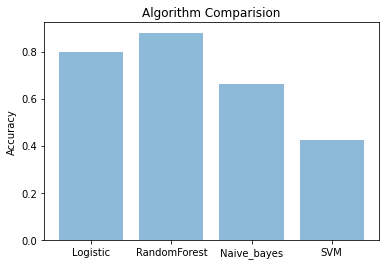

In [40]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

In [41]:
# confusion_matrix = confusion_matrix(y_test,y_preds)
# matrix_proportions = np.zeros((3,3))
# for i in range(0,3):
#     matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
# names=['Hate','Offensive','Neither']
# confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
# plt.figure(figsize=(5,5))
# sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
# plt.ylabel(r'True Class',fontsize=14)
# plt.xlabel(r'Predicted Class',fontsize=14)
# plt.tick_params(labelsize=12)

## Combining different features

In [42]:
#f1, f3 and f4 combined
tfidf_a = tfidf.toarray()
modelling_features_one = np.concatenate([tfidf_a,doc2vec_df,fFeatures],axis=1)
modelling_features_one.shape

(24783, 6454)

In [43]:
X = pd.DataFrame(modelling_features_one)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3 )

              precision    recall  f1-score   support

           0       0.60      0.10      0.18       279
           1       0.89      0.97      0.93      3852
           2       0.85      0.74      0.80       826

    accuracy                           0.89      4957
   macro avg       0.78      0.61      0.63      4957
weighted avg       0.87      0.89      0.87      4957

SVM, Accuracy Score: 0.8860197700221908


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [44]:
#f1, f2 and f4 combined
tfidf_a = tfidf.toarray()
modelling_features_two = np.concatenate([tfidf_a,final_features,fFeatures],axis=1)
modelling_features_two.shape

(24783, 6456)

In [ ]:
X = pd.DataFrame(modelling_features_two)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

In [ ]:
#f2, f3 and f4 combined
modelling_features_three = np.concatenate([final_features,fFeatures],axis=1)
modelling_features_three.shape

In [ ]:
X = pd.DataFrame(modelling_features_three)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3)

In [ ]:
X = pd.DataFrame(modelling_features_two)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train_features,y_train)
y_preds = nb.predict(X_test_features)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

In [ ]:
X = pd.DataFrame(modelling_features_two)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train,y_train)
y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

In [ ]:
X = pd.DataFrame(modelling_features_three)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_preds = rf.predict(X_test)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:", acc1)

In [ ]:
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Class',fontsize=14)
plt.xlabel(r'Predicted Class',fontsize=14)
plt.tick_params(labelsize=12)